## Loading the graphs
We load the graph as a weighted undirected graph.

To load the graph we are using the sister package of Embiggen called [Ensmallen](https://github.com/LucaCappelletti94/ensmallen_graph). Ensmallen is a Rust library with python bindings to handle processing of graph files and preprocessing of data for quickly training embedding models.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

In [2]:
graph_data_dir = "link_prediction_experiment_graph"

In [3]:
# get the graphs

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)
if not os.path.exists(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz"):
    with urllib.request.urlopen("https://zenodo.org/record/4011267/files/kg-covid-19-skipgram-aug-2020.tar.gz") as response, \
        open(graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz", 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

os.system("tar -xvzf " + graph_data_dir + "/kg-covid-19-skipgram-aug-2020.tar.gz -C " + graph_data_dir)

0

In [4]:
%%time
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path= graph_data_dir + "/merged-kg_edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    node_path= graph_data_dir + "/merged-kg_nodes.tsv",
    nodes_column="id",
    node_types_column="category",
    default_node_type="biolink:NamedThing",
    ignore_duplicated_edges=True,
    ignore_duplicated_nodes=True,
    force_conversion_to_undirected=True
)

In [5]:
graph.report()

{'edges_number': '30861027',
 'is_directed': 'false',
 'unique_edge_types_number': '0',
 'traps_rate': '0.021906677500566116',
 'connected_components_number': '8976',
 'degrees_mean': '82.21604837957722',
 'degrees_mode': '1',
 'degrees_min': '0',
 'degrees_median': '6',
 'selfloops_rate': '0.000015391581103247148',
 'singleton_nodes': '8223',
 'density': '0.00021902960686152735',
 'strongly_connected_components_number': '8976',
 'unique_node_types_number': '36',
 'degrees_max': '90378',
 'nodes_number': '375365',
 'bidirectional_rate': '1'}

In [7]:
training, validation = graph.connected_holdout(42, 0.8)

In [8]:
training.report()

{'unique_edge_types_number': '0',
 'degrees_mean': '65.77283976929122',
 'is_directed': 'false',
 'selfloops_rate': '0.000014743514291609376',
 'unique_node_types_number': '36',
 'nodes_number': '375365',
 'degrees_min': '0',
 'edges_number': '24688822',
 'bidirectional_rate': '1',
 'traps_rate': '0.021933318236916067',
 'connected_components_number': '8976',
 'degrees_median': '5',
 'density': '0.0001752236883281372',
 'degrees_max': '71988',
 'singleton_nodes': '8233',
 'degrees_mode': '1',
 'strongly_connected_components_number': '8976'}

In [9]:
validation.report()

{'traps_rate': '0.42166957494705154',
 'density': '0.000043805918533390134',
 'unique_edge_types_number': '0',
 'edges_number': '6172205',
 'bidirectional_rate': '1',
 'degrees_mode': '0',
 'connected_components_number': '162705',
 'nodes_number': '375365',
 'degrees_max': '18390',
 'singleton_nodes': '158280',
 'selfloops_rate': '0.00001798384855979346',
 'degrees_min': '0',
 'unique_node_types_number': '36',
 'degrees_mean': '16.44320861028599',
 'strongly_connected_components_number': '162705',
 'degrees_median': '1',
 'is_directed': 'false'}

The followings are check that are not necessary, but are offered as sanity checks:

In [10]:
assert graph > training
assert graph > validation
assert (training + validation).contains(graph)
assert graph.contains(training + validation)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

## Loading the embeddings

In [11]:
# https://zenodo.org/record/4019808/files/SkipGram_80_20_training_test_epoch_500_delta_0.0001_embedding.npy?download=1
embedding_dir = "link_prediction_experiment_embeddings"
embedding_file = os.path.join(embedding_dir, "SkipGram_embedding.npy")
os.makedirs(embedding_dir, exist_ok=True)

with urllib.request.urlopen("https://zenodo.org/record/4019808/files/SkipGram_80_20_training_test_epoch_500_delta_0.0001_embedding.npy") as response, \
    open(embedding_file, 'wb') as out_file:
        data = response.read()  # a `bytes` object
        out_file.write(data)

In [12]:
import numpy as np
embedding_file = "link_prediction_experiment_embeddings/SkipGram_embedding.npy"
embeddings = np.load(embedding_file)

In [13]:
node_names = list(np.array(training.nodes_reverse_mapping))

In [14]:
assert len(training.nodes_reverse_mapping) == len(embeddings)

In [15]:
assert len(training.node_types) == len(embeddings)

In [16]:
sars_cov_2_name = 'CHEMBL.TARGET:CHEMBL4303835'

In [17]:
sars_cov_2_idx = node_names.index(sars_cov_2_name)

In [18]:
drug_idx = list(np.where(training.node_types == training.node_types_reverse_mapping.index('biolink:Drug'))[0])
drug_names = [node_names[i] for i in drug_idx]

In [19]:
chem_substance_idx = list(np.where(training.node_types == training.node_types_reverse_mapping.index('biolink:ChemicalSubstance'))[0])
chem_substance_names = [node_names[i] for i in chem_substance_idx]

In [20]:
import re
chembl_prefix = 'CHEMBL.COMPOUND'
chembl_names = [x for x in node_names if (match := re.compile(chembl_prefix).search(x))]
chembl_idx = [index for index, x in enumerate(node_names) if (match := re.compile(chembl_prefix).search(x))]

## Loading trained MLP models

In [21]:
from tqdm.auto import tqdm
model_dir = "link_prediction_experiment_models"
os.makedirs(model_dir, exist_ok=True)

h5_files = ["SkipGram_weightedL2_finalized_model.h5", "SkipGram_weightedL1_finalized_model.h5", \
        "SkipGram_hadamard_finalized_model.h5", "SkipGram_average_finalized_model.h5"]
base_url = "https://zenodo.org/record/4031401/files/"

for file in tqdm(h5_files):
    with urllib.request.urlopen(base_url + file) as response, \
        open(os.path.join(model_dir, file), 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [29]:
import tensorflow as tf
mlp_model = ("average", tf.keras.models.load_model('link_prediction_experiment_models/SkipGram_average_finalized_model.h5'))

In [30]:
sars_cov_2_emb = embeddings[sars_cov_2_idx]

In [37]:
print(f"using %s model for edge embeddings" % mlp_model[0])

using average model for edge embeddings


In [32]:
from embiggen import GraphTransformer, EdgeTransformer

assert(mlp_model[0] in EdgeTransformer.methods)

transformer = GraphTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
transformer.fit(embeddings)
train_edges = transformer.transform(training)
assert(training.get_edges_number() == len(train_edges))

In [28]:
# let's try to predict a link that should exist in training graph
# example SARS-CoV-2 -> ChEMBL compound edge (which should be positive)
example_chembl_edge = train_edges[training.get_edge_id(sars_cov_2_idx, chembl_idx[0])]
example_chembl_edge.shape
example_chembl_edge.__class__
mlp_model[1].predict(example_chembl_edge.reshape(1, -1))

(100,) (1, 100)


array([[0.93010485]], dtype=float32)

In [ ]:
# previous value array([[0.93010485]], dtype=float32)

In [84]:
# prepare source (drugs) and destination (SARS-CoV-2) numpy arrays
import logging
import numpy as np
drug_idx_wo_exist_links = []
for drug_id in drug_idx:
    if not training.has_edge(drug_id, sars_cov_2_idx) and not training.has_edge(sars_cov_2_idx, drug_id):
        drug_idx_wo_exist_links.append(drug_id)
    else:
        logging.warning("Not using edge %s %s which was present in training graph" % (drug_id, sars_cov_2_idx))
drug_idx_wo_exist_links = np.asarray(drug_ids_wo_existing_links)
sars_cov_2_dest = np.repeat(sars_cov_2_idx, len(drug_idx_wo_exist_links))

In [85]:
# Make an edge transformer for drug -> SARS-CoV-2 edge for every member of drug_idx

from embiggen import GraphTransformer, EdgeTransformer
assert(mlp_model[0] in EdgeTransformer.methods)

edge_transformer = EdgeTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
assert(drug_idx_wo_exist_links.shape == sars_cov_2_dest.shape)
edge_transformer.fit(embeddings)
drug_edges = edge_transformer.transform(sources=drug_idx_wo_exist_links, destinations=sars_cov_2_dest)
assert(len(drug_idx_wo_exist_links) == len(drug_edges))

drug_prediction_pval = mlp_model[1].predict(drug_edges)

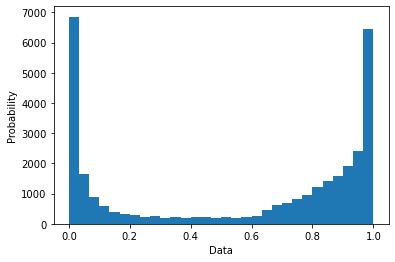

In [90]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(drug_prediction_pval, density=False, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [ ]:
sort_idx = np.argsort(drug_prediction_pval, axis=0)[::-1]

with open("drug_sars_cov2_link_prediction.tsv", "w") as out:
    out.write("graph_id\tCURIE\tpval\n")
    for idx in np.nditer(sort_idx, order='F'):
        line = f"%i    %s     %f\n" % (drug_idx_wo_exist_links[idx],
                        training.nodes_reverse_mapping[drug_idx_wo_exist_links[idx]],
                        drug_prediction_pval[idx])
        print(line)
        out.write(line)

50205    ttd.drug:D03IGB     0.999606

60674    ttd.drug:D0CH7Z     0.999595

40085    CHEBI:83527     0.999540

48755    ttd.drug:D0Y1BF     0.999404

43476    ttd.drug:D04RCT     0.999388

39995    CHEBI:5138     0.999323

67036    ttd.drug:D0K1GJ     0.999284

57511    ttd.drug:D07BMX     0.999226

45240    ttd.drug:D0N1FU     0.999218

53342    ttd.drug:D03BHO     0.999202

39037    DrugCentral:4896     0.999174

46736    ttd.drug:D03IJO     0.999122

48573    ttd.drug:D0S6SN     0.999094

45557    ttd.drug:D0TN1L     0.999081

63193    ttd.drug:D0GF4I     0.999056

39860    PHARMGKB:PA166048654     0.998953

68610    ttd.drug:D0XB1H     0.998940

39551    PHARMGKB:PA451999     0.998940

42284    ttd.drug:D03GAX     0.998936

68313    ttd.drug:D06NGR     0.998911

62114    ttd.drug:D00LVW     0.998880

56288    ttd.drug:D0E0JO     0.998874

55765    ttd.drug:D0D4LF     0.998871

50307    ttd.drug:D00QSV     0.998861

47840    ttd.drug:D08WIJ     0.998821

43119    ttd.drug:D0L5DZ  

44487    ttd.drug:D0I8CA     0.998303

41811    ttd.drug:D04FXD     0.998302

55085    ttd.drug:D0M9VZ     0.998302

53726    ttd.drug:D0Q7SF     0.998302

49261    ttd.drug:D0A8JM     0.998301

54662    ttd.drug:D0V7EK     0.998300

43443    ttd.drug:D0U3ZP     0.998300

46202    ttd.drug:D09PUW     0.998300

61516    ttd.drug:D0B6GK     0.998300

64064    ttd.drug:D0VS7X     0.998299

66011    ttd.drug:D0TK7B     0.998295

52608    ttd.drug:D0E0RP     0.998295

54619    ttd.drug:D0J5AU     0.998294

61814    ttd.drug:D0D6GI     0.998294

51933    ttd.drug:D09WKT     0.998293

54928    ttd.drug:D0WG8L     0.998292

60039    ttd.drug:D0W9ZY     0.998291

42836    ttd.drug:D0L6HX     0.998291

67091    ttd.drug:D06EDH     0.998290

47292    ttd.drug:D02DSZ     0.998290

63063    ttd.drug:D0R3IN     0.998289

51219    ttd.drug:D0X1SN     0.998288

53157    ttd.drug:D0CU9M     0.998287

52691    ttd.drug:D04JEH     0.998287

67958    ttd.drug:D05DCW     0.998287

58827    ttd.drug:D01VCB 

60579    ttd.drug:D0XB4P     0.998197

43025    ttd.drug:D0E3SH     0.998197

68494    ttd.drug:D0K7WW     0.998197

61759    ttd.drug:D08OPX     0.998197

67379    ttd.drug:D06SWT     0.998197

52573    ttd.drug:D0RD6G     0.998196

63414    ttd.drug:D01DPN     0.998196

60264    ttd.drug:D0MN3D     0.998195

58058    ttd.drug:D01JWH     0.998195

42799    ttd.drug:D08SKU     0.998195

55914    ttd.drug:D07ZCP     0.998194

67421    ttd.drug:D03CTH     0.998194

62500    ttd.drug:D0Q8CE     0.998193

54591    ttd.drug:D0Y2TE     0.998193

43681    ttd.drug:D0A4FA     0.998193

64599    ttd.drug:D0I5QL     0.998193

46419    ttd.drug:D0V4EK     0.998193

51153    ttd.drug:D0X5TB     0.998193

57505    ttd.drug:D07VFD     0.998192

67049    ttd.drug:D0C3OH     0.998192

54590    ttd.drug:D0WB1D     0.998191

67355    ttd.drug:D0L1PO     0.998191

42872    ttd.drug:D05YUT     0.998191

43696    ttd.drug:D07WFU     0.998190

41822    ttd.drug:D05EPY     0.998189

47217    ttd.drug:D0H8XV 

43616    ttd.drug:D04SJC     0.998120

49350    ttd.drug:D00AWM     0.998120

48769    ttd.drug:D0E6ON     0.998119

64105    ttd.drug:D0LL0X     0.998119

65090    ttd.drug:D0HL1X     0.998118

50168    ttd.drug:D05RJP     0.998117

67775    ttd.drug:D0NL2L     0.998117

63051    ttd.drug:D0I2AG     0.998117

55535    ttd.drug:D03LAB     0.998116

65809    ttd.drug:D0L5KK     0.998116

46190    ttd.drug:D0F1RU     0.998116

53345    ttd.drug:D0YA7R     0.998115

60267    ttd.drug:D0R9ON     0.998115

43690    ttd.drug:D0H5MV     0.998114

54903    ttd.drug:D0S8HD     0.998114

65829    ttd.drug:D0M2TG     0.998113

49377    ttd.drug:D0A0UR     0.998113

52432    ttd.drug:D04ZYA     0.998113

45415    ttd.drug:D0UK7K     0.998113

40930    ttd.drug:D02RIG     0.998112

47413    ttd.drug:D0R3LP     0.998111

44522    ttd.drug:D03CVT     0.998111

50749    ttd.drug:D0ZM5O     0.998110

66790    ttd.drug:D0D5YE     0.998110

68902    ttd.drug:D0P6GH     0.998110

45732    ttd.drug:D0I1DZ 

54732    ttd.drug:D03HBZ     0.998045

66440    ttd.drug:D08CBB     0.998045

54580    ttd.drug:D0AQ3K     0.998045

47245    ttd.drug:D05KUP     0.998045

68142    ttd.drug:D0Z7BO     0.998045

47417    ttd.drug:D0Y0KU     0.998045

56048    ttd.drug:D0X5ZA     0.998045

57762    ttd.drug:D0BC6Q     0.998045

43234    ttd.drug:D0PP3Q     0.998044

42167    ttd.drug:D00VHG     0.998044

51855    ttd.drug:D0P9BT     0.998044

56567    ttd.drug:D0I9LH     0.998044

47492    ttd.drug:D0B2TV     0.998042

59764    ttd.drug:D03MJJ     0.998042

55384    ttd.drug:D0T1GG     0.998042

64945    ttd.drug:D0N5YD     0.998041

66399    ttd.drug:D0IA5O     0.998041

69574    ttd.drug:D0I3EE     0.998041

47297    ttd.drug:D05NRI     0.998041

53192    ttd.drug:D0B8EP     0.998041

47301    ttd.drug:D03DRW     0.998041

45414    ttd.drug:D0O2HK     0.998041

41059    ttd.drug:D0A8HX     0.998040

68716    ttd.drug:D09LKZ     0.998040

52093    ttd.drug:D0F9RK     0.998040

51938    ttd.drug:D0D5SK 

60966    ttd.drug:D06AGN     0.997985

44371    ttd.drug:D0GA0Y     0.997985

44174    ttd.drug:D09TSC     0.997985

68577    ttd.drug:D0Z9TM     0.997984

56067    ttd.drug:D0HD9K     0.997984

42208    ttd.drug:D0O5GK     0.997984

61562    ttd.drug:D0U4DT     0.997984

69067    ttd.drug:D0E5TD     0.997984

52476    ttd.drug:D01YNL     0.997984

61762    ttd.drug:D0ZK2G     0.997984

63701    ttd.drug:D0R0YB     0.997983

48943    ttd.drug:D09RWW     0.997983

49375    ttd.drug:D07URD     0.997982

50394    ttd.drug:D0J2UD     0.997981

42753    ttd.drug:D0CC8L     0.997981

48516    ttd.drug:D08TDE     0.997981

68396    ttd.drug:D0O4IV     0.997981

56191    ttd.drug:D0ZL9B     0.997981

43558    ttd.drug:D01SBZ     0.997981

53129    ttd.drug:D0B8DF     0.997980

69467    ttd.drug:D0NL4R     0.997980

51247    ttd.drug:D0H6AA     0.997979

39766    DRUGBANK:DB04884     0.997979

42430    ttd.drug:D0G2WI     0.997979

69064    ttd.drug:D02YVB     0.997979

57050    ttd.drug:D05FRX

67471    ttd.drug:D0VF5B     0.997926

59797    ttd.drug:D0L0QR     0.997926

55548    ttd.drug:D02QQB     0.997925

65065    ttd.drug:D0B7AH     0.997924

42874    ttd.drug:D0W7VX     0.997923

62045    ttd.drug:D03POY     0.997923

56945    ttd.drug:D05JGX     0.997923

44550    ttd.drug:D02RZC     0.997922

41066    ttd.drug:D05KJX     0.997922

50833    ttd.drug:D0T6MU     0.997922

63759    ttd.drug:D05MEW     0.997922

67523    ttd.drug:D0AK2Y     0.997922

57801    ttd.drug:D0H3CW     0.997922

47324    ttd.drug:D07TGY     0.997921

43102    ttd.drug:D0YT8O     0.997921

45739    ttd.drug:D0T5TU     0.997921

65983    ttd.drug:D00YQI     0.997920

61972    ttd.drug:D04KKT     0.997920

51666    ttd.drug:D04MOF     0.997920

54608    ttd.drug:D04ZWS     0.997920

60883    ttd.drug:D0MC3R     0.997920

54612    ttd.drug:D03UCC     0.997918

69025    ttd.drug:D05SSB     0.997918

59577    ttd.drug:D07JRL     0.997918

62988    ttd.drug:D06VYT     0.997918

65116    ttd.drug:D0R2AI 

50334    ttd.drug:D0J2ID     0.997871

60046    ttd.drug:D05HSI     0.997871

60230    ttd.drug:D0S9NB     0.997871

68080    ttd.drug:D00RAK     0.997870

58855    ttd.drug:D0Z0VL     0.997870

67525    ttd.drug:D0Y3UB     0.997870

43084    ttd.drug:D0BY1R     0.997869

47163    ttd.drug:D0Y2HR     0.997869

53250    ttd.drug:D0QG9A     0.997869

67585    ttd.drug:D07CMZ     0.997868

53328    ttd.drug:D0UI7K     0.997868

51630    ttd.drug:D0FG6M     0.997868

49326    ttd.drug:D01PYU     0.997867

40989    ttd.drug:D09KWS     0.997867

54572    ttd.drug:D0A5FO     0.997867

52546    ttd.drug:D0W5ZQ     0.997866

65449    ttd.drug:D07ADU     0.997866

46011    ttd.drug:D08PIE     0.997866

67090    ttd.drug:D0WL1Z     0.997864

54643    ttd.drug:D0B0ZM     0.997864

62047    ttd.drug:D0L5KF     0.997864

64066    ttd.drug:D0OK3K     0.997864

60114    ttd.drug:D0V2NH     0.997863

43517    ttd.drug:D0IZ1D     0.997863

56608    ttd.drug:D07CNY     0.997863

43168    ttd.drug:D03ZUZ 

66047    ttd.drug:D06UPS     0.997806

52415    ttd.drug:D04JUJ     0.997805

40990    ttd.drug:D0AC7C     0.997805

53718    ttd.drug:D0G5ET     0.997804

58278    ttd.drug:D0HR8H     0.997804

55184    ttd.drug:D0Q0IE     0.997804

54912    ttd.drug:D01WJM     0.997804

60239    ttd.drug:D0W6PE     0.997803

47574    ttd.drug:D08YGW     0.997803

57058    ttd.drug:D09XOC     0.997802

41027    ttd.drug:D0E3SF     0.997802

65400    ttd.drug:D0KK9E     0.997802

63642    ttd.drug:D0MW7B     0.997801

54617    ttd.drug:D01MAC     0.997801

54570    ttd.drug:D0P3VH     0.997800

54932    ttd.drug:D0Y2NA     0.997800

59914    ttd.drug:D04TSP     0.997800

53627    ttd.drug:D0Q0IR     0.997800

69555    ttd.drug:D02DXP     0.997800

40886    ttd.drug:D04DHZ     0.997800

49180    ttd.drug:D07ANB     0.997800

62083    ttd.drug:D0F5JY     0.997800

52958    ttd.drug:D06RCS     0.997799

46014    ttd.drug:D0KX7I     0.997799

42274    ttd.drug:D0R6RT     0.997799

66314    ttd.drug:D0BI1O 

69460    ttd.drug:D0S9UQ     0.997733

42755    ttd.drug:D0H0FX     0.997733

48983    ttd.drug:D01UAS     0.997732

42823    ttd.drug:D07QAX     0.997732

43633    ttd.drug:D00OLX     0.997732

51779    ttd.drug:D0DR6N     0.997731

47393    ttd.drug:D06EIP     0.997731

69109    ttd.drug:D0T5NX     0.997731

68583    ttd.drug:D0D7NA     0.997730

60238    ttd.drug:D0KT3B     0.997730

55569    ttd.drug:D0F6TS     0.997730

47323    ttd.drug:D0RM9Q     0.997730

54628    ttd.drug:D08BKE     0.997730

41033    ttd.drug:D0W3LI     0.997730

57520    ttd.drug:D0Q3KV     0.997730

64445    ttd.drug:D0L9KW     0.997729

47467    ttd.drug:D0O1GE     0.997729

42891    ttd.drug:D0T4SL     0.997729

61007    ttd.drug:D07VIK     0.997729

63032    ttd.drug:D0UK7B     0.997728

45861    ttd.drug:D0L4PY     0.997728

46404    ttd.drug:D0J5GT     0.997728

51377    ttd.drug:D05HOH     0.997728

43641    ttd.drug:D0D2YR     0.997728

68411    ttd.drug:D03IWC     0.997727

51906    ttd.drug:D0S6NP 

42835    ttd.drug:D00UOI     0.997673

40915    ttd.drug:D0E2CQ     0.997673

47473    ttd.drug:D06ETG     0.997672

66423    ttd.drug:D02IYC     0.997672

64625    ttd.drug:D01FAA     0.997672

67262    ttd.drug:D0B2AE     0.997672

62707    ttd.drug:D0EL3A     0.997672

50903    ttd.drug:D0G5QB     0.997671

48409    ttd.drug:D0D8AK     0.997671

50425    ttd.drug:D0F1DY     0.997671

56545    ttd.drug:D0M5EC     0.997671

62159    ttd.drug:D0RS4B     0.997670

63391    ttd.drug:D0D1GI     0.997670

51864    ttd.drug:D02TKV     0.997670

56867    ttd.drug:D07DCG     0.997670

52094    ttd.drug:D04NUS     0.997670

47458    ttd.drug:D0P7SY     0.997669

55717    ttd.drug:D08QYJ     0.997669

40926    ttd.drug:D02ZRO     0.997668

53091    ttd.drug:D06MIW     0.997668

41983    ttd.drug:D09HNP     0.997668

59063    ttd.drug:D0T6PV     0.997668

60294    ttd.drug:D0PQ8B     0.997668

45675    ttd.drug:D0DT1R     0.997668

67372    ttd.drug:D0G9KS     0.997667

66007    ttd.drug:D06RLO 

56103    ttd.drug:D0D6AC     0.997599

55322    ttd.drug:D08HUB     0.997599

47463    ttd.drug:D01DEU     0.997598

42113    ttd.drug:D0F6TM     0.997598

58224    ttd.drug:D09TGZ     0.997597

67442    ttd.drug:D03RXE     0.997597

66427    ttd.drug:D0T3QU     0.997597

53625    ttd.drug:D0YP0T     0.997597

43821    ttd.drug:D05GYO     0.997596

50396    ttd.drug:D03CEP     0.997596

62980    ttd.drug:D02BPT     0.997595

54647    ttd.drug:D0M6IJ     0.997594

60759    ttd.drug:D0A4ZR     0.997594

58396    ttd.drug:D0C3SW     0.997594

68424    ttd.drug:D0X3TX     0.997594

54792    ttd.drug:D0Z6WI     0.997593

40966    ttd.drug:D0NH7M     0.997593

50854    ttd.drug:D07YFY     0.997593

42086    ttd.drug:D0Z5IU     0.997593

55714    ttd.drug:D0Z4KX     0.997593

56811    ttd.drug:D0Y1UG     0.997592

45837    ttd.drug:D05YFF     0.997592

64824    ttd.drug:D08ZDI     0.997592

68036    ttd.drug:D0Q8BK     0.997591

44423    ttd.drug:D0VY5O     0.997591

49601    ttd.drug:D0H5BC 

64460    ttd.drug:D0R9BP     0.997510

42122    ttd.drug:D04GYD     0.997510

54760    ttd.drug:D07OAF     0.997509

51200    ttd.drug:D0V2PM     0.997509

43911    ttd.drug:D0SM0J     0.997509

43824    ttd.drug:D0D9PD     0.997509

63162    ttd.drug:D0F2SQ     0.997509

55415    ttd.drug:D0ZE2J     0.997509

43120    ttd.drug:D0UC6H     0.997509

43669    ttd.drug:D0P3DV     0.997509

55436    ttd.drug:D07ESG     0.997509

51472    ttd.drug:D02CKX     0.997509

51363    ttd.drug:D0B1JC     0.997508

62921    ttd.drug:D0H2BL     0.997507

44889    ttd.drug:D0G5UW     0.997507

52893    ttd.drug:D0Q5YP     0.997506

55528    ttd.drug:D0S7JH     0.997506

58315    ttd.drug:D08ENK     0.997505

62920    ttd.drug:D02PBS     0.997505

59069    ttd.drug:D00ITG     0.997505

60375    ttd.drug:D0T6WL     0.997504

41067    ttd.drug:D0SB0W     0.997503

45076    ttd.drug:D01CUJ     0.997503

42443    ttd.drug:D09MCN     0.997503

65615    ttd.drug:D08RJY     0.997503

67422    ttd.drug:D0N4TO 

54887    ttd.drug:D09OLZ     0.997402

55428    ttd.drug:D0DA6B     0.997402

67580    ttd.drug:D0O1RL     0.997401

64475    ttd.drug:D02NMG     0.997400

58020    ttd.drug:D04TVU     0.997400

69032    ttd.drug:D05RSP     0.997400

41080    ttd.drug:D0O9YG     0.997399

52535    ttd.drug:D0EP0C     0.997399

45723    ttd.drug:D0Z4EI     0.997396

46083    ttd.drug:D02TGW     0.997395

53831    ttd.drug:D0V0VI     0.997395

57802    ttd.drug:D07QCC     0.997395

54955    ttd.drug:D0C0HP     0.997394

67024    ttd.drug:D07KNI     0.997394

64242    ttd.drug:D0E1YT     0.997393

48926    ttd.drug:D0D6IU     0.997393

55512    ttd.drug:D0O6GN     0.997393

50481    ttd.drug:D03YDP     0.997392

51324    ttd.drug:D05EWZ     0.997392

60085    ttd.drug:D0S4CE     0.997392

66145    ttd.drug:D0M9TO     0.997391

67022    ttd.drug:D0LZ4A     0.997391

50795    ttd.drug:D0N8UY     0.997390

63185    ttd.drug:D09EJG     0.997390

43547    ttd.drug:D04UYZ     0.997388

67498    ttd.drug:D0YX4L 

60286    ttd.drug:D0E0EQ     0.997271

54567    ttd.drug:D0J1IX     0.997271

43643    ttd.drug:D05FMZ     0.997271

62201    ttd.drug:D01SPD     0.997269

41031    ttd.drug:D0Y7TS     0.997269

59023    ttd.drug:D04WRK     0.997269

44822    ttd.drug:D0Y5ZT     0.997269

46749    ttd.drug:D0I1RW     0.997268

55385    ttd.drug:D0X2BP     0.997268

41086    ttd.drug:D0H8AW     0.997267

46241    ttd.drug:D01OHD     0.997266

52538    ttd.drug:D05RZE     0.997265

44565    ttd.drug:D0JC4J     0.997262

53957    ttd.drug:D04LRN     0.997262

68818    ttd.drug:D0L6RV     0.997261

52428    ttd.drug:D0M9TM     0.997261

59585    ttd.drug:D01GEO     0.997261

69549    ttd.drug:D00IWH     0.997260

60368    ttd.drug:D06NDT     0.997259

45740    ttd.drug:D03WNG     0.997259

69341    ttd.drug:D06XQX     0.997259

56199    ttd.drug:D0A1GE     0.997258

62668    ttd.drug:D09GZQ     0.997258

43546    ttd.drug:D0S7FP     0.997255

43454    ttd.drug:D0ST4P     0.997255

65925    ttd.drug:D0D6MO 

44527    ttd.drug:D09ZLZ     0.997049

47132    ttd.drug:D0YG7M     0.997048

57449    ttd.drug:D0N8JG     0.997048

48569    ttd.drug:D04VGL     0.997048

66853    ttd.drug:D0PO8M     0.997044

61082    ttd.drug:D0S9XV     0.997042

67505    ttd.drug:D0QU6N     0.997042

39726    CHEBI:9130     0.997038

47200    ttd.drug:D0PB6B     0.997032

54891    ttd.drug:D04ODH     0.997031

59048    ttd.drug:D03WPA     0.997031

43471    ttd.drug:D0I2VK     0.997030

47352    ttd.drug:D0PM2S     0.997030

62061    ttd.drug:D06WNK     0.997021

52067    ttd.drug:D0TR5T     0.997016

44049    ttd.drug:D06OAL     0.997015

67508    ttd.drug:D00KKD     0.997013

60751    ttd.drug:D09VPP     0.997012

50411    ttd.drug:D06NXG     0.997010

69017    ttd.drug:D0JP7S     0.997008

69183    ttd.drug:D0M1KX     0.997008

62088    ttd.drug:D0G3IT     0.997008

47704    ttd.drug:D09KKU     0.997007

53720    ttd.drug:D0R4JZ     0.997007

63643    ttd.drug:D02YPU     0.997006

62399    ttd.drug:D0M9RQ     0

64062    ttd.drug:D0J0UC     0.996676

43499    ttd.drug:D0I9CK     0.996675

53616    ttd.drug:D0E9JD     0.996669

61513    ttd.drug:D05HBM     0.996665

64987    ttd.drug:D08MHD     0.996664

67524    ttd.drug:D0CN7A     0.996663

40872    ttd.drug:D02BYZ     0.996662

43580    ttd.drug:D03PXS     0.996659

61823    ttd.drug:D0Z7YK     0.996658

46290    ttd.drug:D02CCB     0.996655

58449    ttd.drug:D0R4GX     0.996655

52121    ttd.drug:D0K3OK     0.996655

67359    ttd.drug:D07RQA     0.996654

54918    ttd.drug:D0B6LL     0.996654

47522    ttd.drug:D02AQM     0.996654

43318    ttd.drug:D0H7XL     0.996654

39237    DrugCentral:5251     0.996652

49548    ttd.drug:D05KQC     0.996650

51489    ttd.drug:D01QNX     0.996650

64373    ttd.drug:D00YFP     0.996648

46622    ttd.drug:D0R3UI     0.996645

47307    ttd.drug:D0N7QP     0.996642

49032    ttd.drug:D01PNV     0.996635

51555    ttd.drug:D0F0YZ     0.996634

42345    ttd.drug:D0LT0T     0.996625

60711    ttd.drug:D05XLO

39425    CHEBI:9123     0.996027

43249    ttd.drug:D0K8MF     0.996023

39958    CHEBI:73275     0.996017

43912    ttd.drug:D0J4ZH     0.996009

48717    ttd.drug:D0M5XV     0.996007

47242    ttd.drug:D0R2SK     0.996001

